In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch, torch.nn as nn, torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils

## Preparing Dataset

In [32]:
data = pd.read_csv('creditcard.csv')

In [33]:
#This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions
#variables which are the result of a PCA transformation
#'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
#'Amount' is the transaction Amount
# Class == 0 : normal, Class == 1 : anomaly
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [34]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [35]:
print(data.Class.value_counts())
data.loc[data.Class==1]

0    284315
1       492
Name: Class, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [36]:
data.isna().sum().sum()

0

In [37]:
data['Time'] = data['Time']%86400

In [38]:
# 1. DBSCAN
# 2. isolation forest
# 3. Gaussian 

# + SMOTE

# https://www.kaggle.com/code/nareshbhat/outlier-the-silent-killer

In [39]:
features = data.iloc[:,:-1]
labels = data.iloc[:,-1:]

In [40]:
# train/valid/test = 6/2/2
train_index = int(len(data) * 0.6)
valid_index = int(len(data) * 0.8)
X_train, y_train = features.iloc[:train_index,:], labels.iloc[:train_index,:]
X_val, y_val = features.iloc[train_index:valid_index,:], labels.iloc[train_index:valid_index,:]
X_test, y_test = features.iloc[valid_index:,:], labels.iloc[valid_index:,:]

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train.values).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val.values).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test.values).float()

In [41]:
train = data_utils.TensorDataset(X_train, y_train)
valid = data_utils.TensorDataset(X_val, y_val)
test = data_utils.TensorDataset(X_test, y_test)

trainloader = torch.utils.data.DataLoader(train,batch_size = 256, shuffle=True)
validloader = torch.utils.data.DataLoader(valid,batch_size = 256, shuffle=True)
testloader = torch.utils.data.DataLoader(test,batch_size = 256, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [42]:
data_iter = iter(trainloader)
features, labels = data_iter.next()

print(features.shape)
print(labels.shape)

torch.Size([256, 30])
torch.Size([256, 1])


## Model

In [43]:
# 평가지표 : accuracy
def accuracy(y_pred, y_test) : 
    prediction = y_pred >= torch.FloatTensor([0.5])
    correct_prediction = prediction.float() == y_test
    accuracy = correct_prediction.sum().item() / len(correct_prediction)
    
    return accuracy

In [44]:
# FNN default 모델 구현
class DefaultModel(nn.Module) :
    def __init__(self) :
        super(DefaultModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(30,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
        
    def forward(self, x) :
        # x = x.view(x.size(0),-1)
        x = self.layer1(x)
        return x

In [45]:
# FNN-defalut 학습/평가
loss_fn = nn.BCELoss()
model = DefaultModel()#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_train_df = []
accuracy_train_df = []
loss_val_df = []
accuracy_val_df = []
y_val_list_df = []
y_pred_list_df = []
epochs = 100

for epoch in range(epochs) :
    model.train()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for x_train, y_train in trainloader :
        # x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss
        train_acc += accuracy(y_pred, y_train)
        
    model.eval() 
    with torch.no_grad() :
        correct = 0
        total = 0
        for x_val, y_val in validloader :
            # x_test, y_test = x_test.to(device), y_test.to(device)
            y_pred = model(x_val)
            val_loss += loss_fn(y_pred, y_val)
            val_acc += accuracy(y_pred, y_val)
            # if epoch == 19 :
            #     y_val_list_df.append(y_val.tolist())
            #     y_pred_max = torch.max(y_val,1)
            #     y_pred_list_df.append(y_pred_max.indices.tolist())
            if epoch == 19 :
                y_val_list_df.append(y_val.tolist())
                # y_pred_max = torch.max(y_val,1)
                y_pred = [1 if i >0.5 else 0 for a in y_pred.tolist() for i in a]
                y_pred_list_df.append(y_pred)
    
    loss_train_df.append(train_loss/len(trainloader))
    loss_val_df.append(val_loss/len(validloader))
    accuracy_train_df.append(train_acc/len(trainloader))
    accuracy_val_df.append(val_acc/len(validloader))
   
    
    print('Epoch: {}, train_loss : {:.5f}, val_loss : {:.5f}, train_accuracy : {:.5f}, val_accuracy : {:.5f}'\
        .format(epoch+1,train_loss/len(trainloader),val_loss/len(validloader), train_acc/len(trainloader), val_acc/len(validloader)))

Epoch: 1, train_loss : 0.02555, val_loss : 0.00300, train_accuracy : 0.99420, val_accuracy : 0.99963
Epoch: 2, train_loss : 0.00371, val_loss : 0.00249, train_accuracy : 0.99926, val_accuracy : 0.99953
Epoch: 3, train_loss : 0.00361, val_loss : 0.00240, train_accuracy : 0.99918, val_accuracy : 0.99968
Epoch: 4, train_loss : 0.00345, val_loss : 0.00292, train_accuracy : 0.99923, val_accuracy : 0.99968
Epoch: 5, train_loss : 0.00335, val_loss : 0.00643, train_accuracy : 0.99926, val_accuracy : 0.99947
Epoch: 6, train_loss : 0.00319, val_loss : 0.00245, train_accuracy : 0.99925, val_accuracy : 0.99967
Epoch: 7, train_loss : 0.00302, val_loss : 0.00291, train_accuracy : 0.99930, val_accuracy : 0.99961
Epoch: 8, train_loss : 0.00299, val_loss : 0.00258, train_accuracy : 0.99930, val_accuracy : 0.99967
Epoch: 9, train_loss : 0.00280, val_loss : 0.00294, train_accuracy : 0.99935, val_accuracy : 0.99961
Epoch: 10, train_loss : 0.00258, val_loss : 0.01687, train_accuracy : 0.99936, val_accuracy

### training loss

In [46]:
# 형변환(cuda -> numpy)
def cuda_numpy(data_cuda) :
    data_numpy = [i.cpu().detach().numpy() for i in data_cuda]
    return data_numpy

Text(0.5, 1.0, 'train_loss')

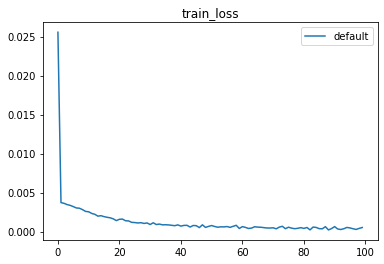

In [47]:
# plt.plot(cuda_numpy(loss_train_lr), label='logistic')
plt.plot(cuda_numpy(loss_train_df), label='default')
# plt.plot(cuda_numpy(loss_train_bn), label='batch_norm')
# plt.plot(cuda_numpy(loss_train_dr), label='dropout')
plt.legend()
plt.title('train_loss')

In [48]:
# FNN-default confusion matrix 확인
# x = np.array(y_pred_list_df).flatten()
# y = np.array(y_val_list_df).flatten()
# confusion_matrix(x,y)
# confusion_matrix_df = pd.DataFrame(confusion_matrix(x,y)/np.sum(confusion_matrix(x,y)))#,index = [0 ,1], columns = [0,1])
# plt.figure(figsize = (12,10))
# plt.title('default')
# sns.heatmap(confusion_matrix_df, annot=True)
# x = y_pred_list_df
# y = y_val_list_df
# confusion_matrix(x,y)
# f y_pred_list_df
# x.flatten()
x = [a for b in y_val_list_df for a in b]
y = [a for b in y_pred_list_df for a in b]
confusion_matrix(x,y)

array([[56899,     5],
       [   16,    41]])

In [49]:
print(classification_report(x, y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56904
         1.0       0.89      0.72      0.80        57

    accuracy                           1.00     56961
   macro avg       0.95      0.86      0.90     56961
weighted avg       1.00      1.00      1.00     56961



# test set 평가 : confusion matrix, f1-score, PR-AUC

In [50]:
model.eval() 
test_list = []
pred_list = []
prob_list = []

with torch.no_grad() :
    correct = 0
    total = 0
    for x_test, y_test in testloader :
        # x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred = model(x_test)
        test_list.append(y_test.tolist())
        # y_pred_max = torch.max(y_pred,1)
        prob_list.append(y_pred)
        y_pred = [1 if i >0.5 else 0 for a in y_pred.tolist() for i in a]
        pred_list.append(y_pred)
        # print(pred_list)

### confusion matrix

In [51]:
x_ = [a for b in test_list for a in b]
y_ = [a for b in pred_list for a in b]
y_prob = [a for b in prob_list for a in b]
confusion_matrix(x_,y_)

array([[56848,    39],
       [   16,    59]])

### f1-score

In [52]:
print(classification_report(x_, y_))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56887
         1.0       0.60      0.79      0.68        75

    accuracy                           1.00     56962
   macro avg       0.80      0.89      0.84     56962
weighted avg       1.00      1.00      1.00     56962



### PR-AUC curve

In [53]:
from sklearn.metrics import precision_recall_curve, average_precision_score 
def pr_auc(target, losses):

    precision, recalls, threshold = precision_recall_curve(target, losses) # _ = threshold
    average_precision = average_precision_score(target, losses)
    # print(precision)
    # print(recalls)
    # print(threshold)
    print("Average precision-recall score: {0:.4f} ".format(average_precision))

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(recalls, precision, label="precision & recall")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend()
    plt.grid()
    plt.show()

Average precision-recall score: 0.7810 


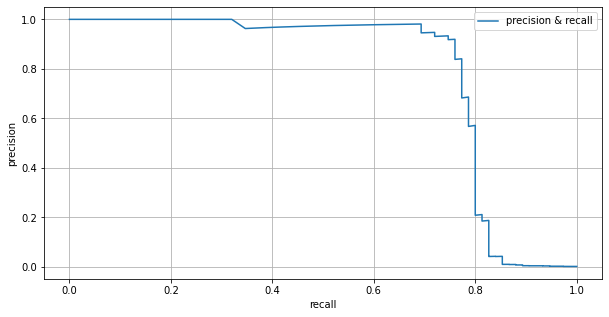

In [54]:
pr_auc(x_,y_prob)
# loss_val_df